# Text Classification / Sentiment Analysis with Naive Bayes

This mini-project is based on Lab 10 of Harvard's CS109 class. 

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Rotten Tomatoes Dataset

In [2]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.head()

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,fresh,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,fresh,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,fresh,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,fresh,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,fresh,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story


In [3]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size

print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


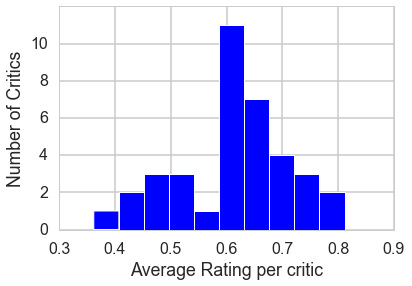

In [4]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

### Ex.1

* 0.6 is the most commonly used rating by the critics 
* most critics have used > 0.5 rating 
* The distribution is  semi-normal distribution with a gap in the rating counts from 0.5 to 0.6

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

## Naive Bayes

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf = MultinomialNB()
clf.fit(X_train, y_train)
print("Accuracy (Training Set): ", accuracy_score(y_train, clf.predict(X_train)))
print("Accuracy (Test Set): ", accuracy_score(y_test, clf.predict(X_test)))

Accuracy (Training Set):  0.9207675358060963
Accuracy (Test Set):  0.7740415506532448


In [7]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix - Training Set")
print(confusion_matrix(y_train, clf.predict(X_train)))
print("Confusion Matrix - Test Set")
print(confusion_matrix(y_test, clf.predict(X_test)))

Confusion Matrix - Training Set
[[3655  598]
 [ 265 6374]]
Confusion Matrix - Test Set
[[1163  663]
 [ 392 2451]]


## Ex.2 
* Accuracy of the classifier is higher for the training set than for the test set(overfitting ?)  
* The model (multinominal Naive Bayes classifier) may not perform well for  new/unseen data.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

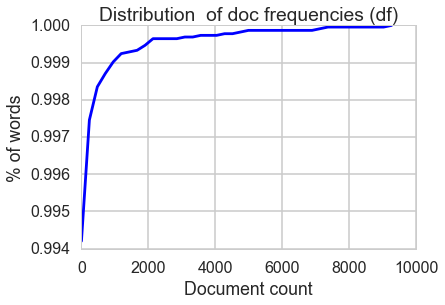

In [8]:

X_bin = X.copy()
X_bin[np.nonzero(X_bin)] = 1 

freq = X_bin.sum(axis=0)

# create histogram
values, base = np.histogram(freq, bins=40)

# evaluate the cumulative
cumulative = np.cumsum(values)

# convert to cumulative percentages
cumPercent = cumulative/cumulative[-1]

# plot the cumulative function
plt.plot(base[:-1], cumPercent, c='blue')

# show plot

plt.title('Distribution  of doc frequencies (df)')
plt.xlabel('Document count')
plt.ylabel('% of words')
plt.show()

In [9]:
values

array([22287,    73,    20,     8,     7,     5,     1,     1,     3,
           4,     0,     0,     0,     1,     0,     1,     0,     0,
           1,     0,     1,     1,     0,     0,     0,     0,     0,
           0,     0,     0,     1,     1,     0,     0,     0,     0,
           0,     0,     0,     1])

### Ex.3 
From the plot of word frequences above, we choose min_df = 1 , max_df=6 as optimal value

In [10]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [11]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [12]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

/Applications/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

### Ex IV 
* Using the  log_likelihood, we  find the parameters that maximize the probability of predicting the training data. 
* A larger alpha will reduce the variance of the model (and overfitting) but increase bias at the same time. 
* We find the best alpha using the grid search below

In [13]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]

min_dfs = [.00001, .0001, .001, .01, .1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        
        #your code here
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

/Applications/anaconda/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [14]:
print("alpha : {}".format(best_alpha))
print("min_df: {}".format(best_min_df))

alpha : 5
min_df: 0.001


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [15]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.811309
Accuracy on test data:     0.718784


In [16]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2077 2175]
 [ 888 5752]]


### Ex.5 
* Using the best value for alpha,min_df , we have reduced the overfitting 
* The model accuracy drops from 92% to 79.7% for the training set 
* The accuracy on the test set drops from 76% to 71% , but the model is probably more accurate in predicting new data.

## Interpretation

In [17]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:15]]
bad_words = words[ind[-15:]]

good_prob = probs[ind[:15]]
bad_prob = probs[ind[-15:]]

#print("Good words\t     P(fresh | word)")
print("{:>20}".format("Good Words"), "Probabilities")
print('\t---------------------------')
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
#print("Bad words\t     P(fresh | word)")
print("\n{:>20}".format("Bad Words"), "Probabilities")
print('\t---------------------------')
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

          Good Words Probabilities
	---------------------------
           beautiful 0.86
               great 0.85
            greatest 0.85
             delight 0.83
        entertaining 0.83
              moving 0.83
           wonderful 0.81
         intelligent 0.81
               among 0.81
             perfect 0.81
            powerful 0.81
               truth 0.81
                 top 0.80
         brilliantly 0.80
                epic 0.80

           Bad Words Probabilities
	---------------------------
               wrong 0.31
             unfunny 0.30
         development 0.30
                dull 0.30
            tiresome 0.30
          uninspired 0.30
     disappointingly 0.30
      disappointment 0.30
               video 0.30
            supposed 0.28
           pointless 0.27
              except 0.27
                flat 0.25
                lame 0.24
       unfortunately 0.22


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

### Ex.6 
The probability for each row in the identify matrix represents the predictive power of each word in the feature set

### Prediction Errors

We can see mis-predictions as well.

In [18]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:3]
bad_fresh = np.argsort(prob[y == 1])[-3:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Nava, who started his feature-film career with El Norte, is a good director who invariably finds a strong rapport with his actors. He's not much of a writer, though, and he should think twice about creating dialogue for his future projects.

I know that Platoon is being acclaimed for its realism, and I expect to be chastened for being a woman finding fault with a war film. But I've probably seen as much combat as most of the men saying, 'This is how war is.'

The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

Mis-predicted Fresh quotes
--------------------------
Some of the gags don't work, but fewer than in any previous Brooks film that I've seen, and when the jokes are meant to be bad, they are riotously poor. What more can one ask of Mel Brooks?

Though it's a good half hour too long, thi

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [19]:
newtext = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])  
str = "Fresh" if clf.predict(newtext) == 1 else "Rotten"
print(str)
print(clf.predict_proba(newtext))

Fresh
[[0.07612627 0.92387373]]


### Ex.7 
* The classifier with best tuning parameters predicts the new review as fresh with a probability of 93%, even though it is negative review . 
* Since the words are taken into account individully , the effect of 'not' which negates the meaning is not accounted by the model 
* We look at several alternatives from using phrases/multi-words (n-grams) to RandomForests and TF-IDF models below 

<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

# BI-GRAMS N-GRAMS

In [20]:
ng_vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=best_min_df, max_df=0.1)
X, y = make_xy(critics, ng_vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.838938
Accuracy on test data:     0.722273


In [21]:
words = np.array(ng_vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:15]]
bad_words = words[ind[-15:]]

good_prob = probs[ind[:15]]
bad_prob = probs[ind[-15:]]

#print("Good words\t     P(fresh | word)")
print("{:>20}".format("Good Words"), "Probabilities")
print('\t---------------------------')
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
#print("Bad words\t     P(fresh | word)")
print("\n{:>20}".format("Bad Words"), "Probabilities")
print('\t---------------------------')
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

          Good Words Probabilities
	---------------------------
           beautiful 0.87
               great 0.86
            greatest 0.85
             delight 0.84
            the best 0.84
        entertaining 0.84
              moving 0.84
           wonderful 0.82
         intelligent 0.82
               among 0.82
             perfect 0.82
            powerful 0.82
               truth 0.82
                 top 0.81
         brilliantly 0.81

           Bad Words Probabilities
	---------------------------
      disappointment 0.31
           that made 0.31
            tiresome 0.31
          would have 0.31
          uninspired 0.31
     disappointingly 0.31
             far too 0.31
            supposed 0.29
          not enough 0.29
         supposed to 0.29
           pointless 0.28
              except 0.28
                flat 0.26
                lame 0.26
       unfortunately 0.24


In [22]:
newtext = ng_vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
str = "Fresh" if clf.predict(newtext) == 1 else "Rotten"
print(str)
print(clf.predict_proba(newtext))

Fresh
[[0.08056168 0.91943832]]


### Ex.8
* We find the classifier using bi-grams and best tuning parameters has 82% accuracy on training data and 71% accuracy on the test data
* the model classifies the new review as fresh with a probability of 92% ! 

# RandomForest 

In [23]:
from sklearn.ensemble import RandomForestClassifier

ns = [10, 30, 60, 90]
min_dfs = [0.00001, 0.0001, 0.001, 0.01]
best_n = None
best_min_df = None
maxscore=-np.inf

for n in ns: 
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df=min_df)       
        X, y = make_xy(critics, vectorizer)
        Xtrain = X[mask]
        ytrain = y[mask]
        
        clf = RandomForestClassifier(n_estimators=n, random_state=5)
        result = 0
        for train, test in KFold(5).split(Xtrain):
            clf.fit(Xtrain[train],ytrain[train])
            result += clf.score(Xtrain[test],ytrain[test])
            score = result / 5
        if score > maxscore:
            maxscore = score
            best_min_df = min_df
            best_n = n


In [24]:
print('Best # trees: {}\nBest min_df: {:.5f}'.format(best_n,best_min_df))
vectorizer = CountVectorizer(min_df=best_min_df)       
X, y = make_xy(critics, vectorizer)
Xtrain = X[mask]
ytrain = y[mask]
Xtest = X[~mask]
ytest = y[~mask]

clf = RandomForestClassifier(n_estimators=best_n, random_state=5).fit(Xtrain, ytrain)
training_accuracy = clf.score(Xtrain, ytrain)
test_accuracy = clf.score(Xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Best # trees: 30
Best min_df: 0.00010
Accuracy on training data: 0.999357
Accuracy on test data:     0.679306


In [25]:
newtext = vectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
str = "Fresh" if clf.predict(newtext) == 1 else "Rotten"
print(str)
print(clf.predict_proba(newtext))

Fresh
[[0.2 0.8]]


### Ex.8 
* We find the classifier using RandomForests (with best tuning parameters) has 100% accuracy on training data and 67% accuracy on the test data
* Even with high accuracy the Random Forest classifier misclassifies a review describing a 'not remarkable' movie as fresh with a probability of 71% ! 

# TF-IDF

In [26]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)
X = Xtfidf.tocsc()  # some versions of sklearn return COO format
y = (critics.fresh == 'fresh').values.astype(np.int)

xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.621975
Accuracy on test data:     0.612192


In [27]:
# TF-IDF 
from sklearn.feature_extraction.text import TfidfVectorizer


In [28]:
# Specify the grid of parameters to search over
alphas = [0.1, 1, 5, 10]
min_dfs = [0, 0.00001, 0.0001, 0.001]
max_dfs = [0.05, 0.1, 0.3, 0.5, 0.7]

# Find the best value for alpha and min_df, and the best NB classifier with bigrams
best_alpha = None
best_min_df = None
best_max_df = None
maxscore=-np.inf
for alpha in alphas: 
    for min_df in min_dfs:
        for max_df in max_dfs:
            tfidfvectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, stop_words='english')      
            Xthis, ythis = make_xy(critics, tfidfvectorizer)
            Xtrainthis = Xthis[mask]
            ytrainthis = ythis[mask]
            clf = MultinomialNB(alpha=alpha)
            score = cv_score(clf, Xtrainthis, ytrainthis, scorefunc=log_likelihood)
            if score > maxscore:
                maxscore = score
                best_alpha = alpha
                best_min_df = min_df
                best_max_df = max_df


In [29]:
tfidfvectorizer = TfidfVectorizer(best_min_df, best_max_df, stop_words='english')
X, y = make_xy(critics, tfidfvectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

# Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))


Accuracy on training data: 0.973656
Accuracy on test data:     0.718325


In [30]:
newtext = tfidfvectorizer.transform(['This movie is not remarkable, touching, or superb in any way'])
str = "Fresh" if clf.predict(newtext) == 1 else "Rotten"
print(str)
print(clf.predict_proba(newtext))

Fresh
[[0.00745141 0.99254859]]


### Ex.8 - TF-IDF 
* We find the classifier using TF-IDF and best tuning parameters has 97% accuracy on training data and 71% accuracy on the test data
* This model also classifies the new review as fresh with a probability of 99% 